In [1]:
import pandas as pd
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
# Visualize
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots
import time
from itertools import product
import xgboost
import gc
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBRegressor
from xgboost import plot_importance

In [2]:
data = pd.read_pickle('all_data.pkl')

In [3]:
data = data[data.date_block_num >11]
X_train = data[(data.date_block_num < 33)].drop(['item_cnt_month'], axis=1)
Y_train = data[(data.date_block_num < 33)]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
del data
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [8]:
import gc
gc.collect();

In [9]:
#import xgboost
model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.7, 
    eta=0.01,
    #tree_method='gpu_hist',
    seed=0)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 30
    )

[18:16:02] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:16:02] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.12065	validation_1-rmse:1.11613
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:1.07692	validation_1-rmse:1.0793
[2]	validation_0-rmse:1.04085	validation_1-rmse:1.04764
[3]	validation_0-rmse:0.994778	validation_1-rmse:1.01886
[4]	validation_0-rmse:0.964178	validation_1-rmse:0.996796
[5]	validation_0-rmse:0.940511	validation_1-rmse:0.979489
[6]	validation_0-rmse:0.918872	validation_1-rmse:0.963386
[7]	vali

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=0.5, missing=None,
             n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=0, silent=None, subsample=0.7, verbosity=1)

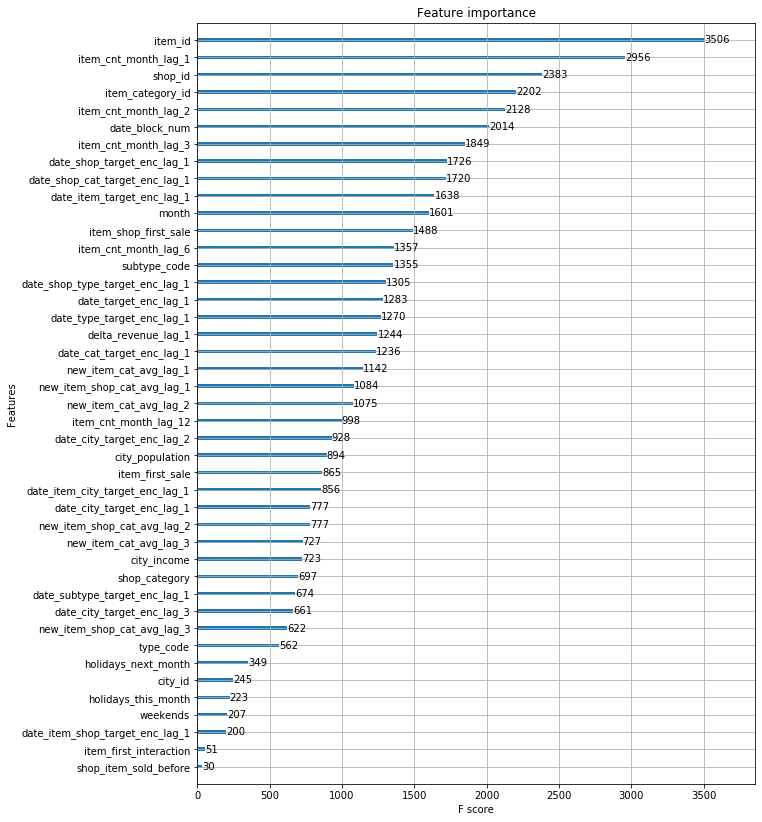

In [10]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

In [11]:
path = "/Users/williamchen/Documents/Kaggle/predict_future_sales/predict_future_sales_data/"
test = pd.read_csv(path+"test.csv",index_col='ID')
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('test_xgb_git.csv', index=False)